# Project 1
## Wolesale
### 1. load data
we load the data from a csv and then do something

In [2]:
%matplotlib inline
import numpy as np
import scipy,scipy.spatial
import torch
import torchvision,torchvision.transforms
import sqlite3
import matplotlib
from matplotlib import pyplot as plt

raw_data = np.genfromtxt("Wholesale customers data.csv", skip_header=1, delimiter=",")


In [3]:
# we are not interested in the region 
_data_no_log = np.delete(raw_data, (1), axis=1) 
_data_log = _data_no_log.copy()
_data_log[:, 1:] = np.log10(1 + _data_log[:, 1:])
data = _data_log # set to data_log instead for compressed data

# seperating by channel
is_horeca = (data[:, 0]-1) == 0
data_horeca = data[is_horeca, 1:]
data_retail = data[~is_horeca, 1:]

# total spending in the catagories
totals = np.sum(data[:, 1:], axis=1)

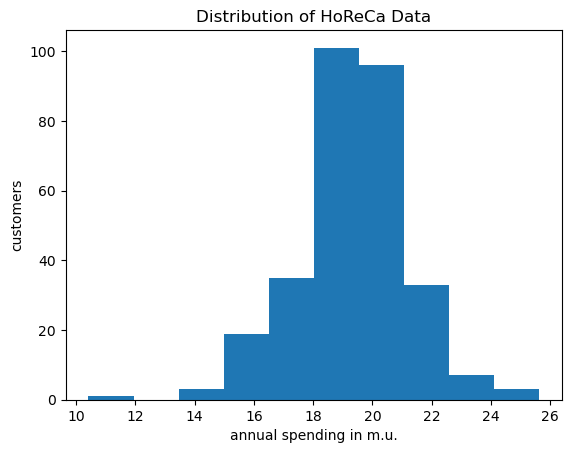

In [34]:
# we want to visualize the data to get a general overview
# we want to visualize the data to get a general overview
def graph_histogram(data, bin_count:int, name:str):

    _, ax = plt.subplots()
    plt.hist(data, bins=bin_count)

    #plt.xscale('log')
    ax.set_title(f'Distribution of {name} Data')
    ax.set_xlabel('annual spending in m.u.')
    ax.set_ylabel('customers')

horeca_totals = np.sum(data_horeca, axis=1)
graph_histogram(horeca_totals, 10, "HoReCa")
plt.show()

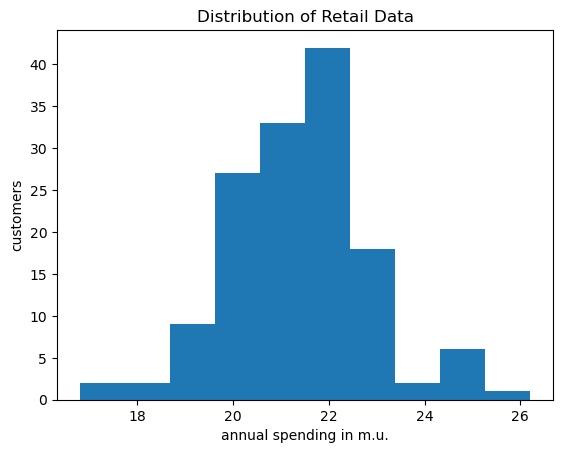

In [35]:
# we want to visualize the data to get a general overview

retail_totals = np.sum(data_retail, axis=1)
graph_histogram(retail_totals, 10, "Retail")
plt.show()

In [6]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Load the dataset
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(data_url)

# Select the features for anomaly detection
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
X = df[features].values

# Calculate the pairwise distances between data points
distances = cdist(X, X, metric='euclidean')

# Compute the anomaly scores
N = len(X)
gamma = 1.0  # Adjust this parameter to control the softness of the minimum
anomaly_scores = np.zeros(N)

for j in range(N):
    zjk = distances[j, np.arange(N) != j]
    anomaly_scores[j] = -1 / gamma * np.log(np.mean(np.exp(-gamma * zjk)))

# Rank the data points based on their anomaly scores
sorted_indices = np.argsort(anomaly_scores)
most_anomalous_indices = sorted_indices[-10:]  # Select top 10 most anomalous instances

# Perform Layer-wise Relevance Propagation (LRP) to attribute anomaly scores to input features
attributions = np.zeros((N, len(features)))

for j in range(N):
    R_k = np.exp(-gamma * distances[j, np.arange(N) != j]) / np.sum(np.exp(-gamma * distances[j, np.arange(N) != j])) * anomaly_scores[j]
    R_i = np.dot((X[j] - X[np.arange(N) != j]).T, (X[j] - X[np.arange(N) != j])) / np.linalg.norm(X[j] - X[np.arange(N) != j], ord=2, axis=1)**2 * R_k
    attributions[j] = R_i

# Print the explanations for the most anomalous instances
for i, idx in enumerate(most_anomalous_indices):
    explanation = "Explanation for anomaly {} at index {}: ".format(i+1, idx)
    explanation += ", ".join(["{}: {:.2f}".format(features[j], attributions[idx, j]) for j in range(len(features))])
    print(explanation)

C:\Users\saraw\AppData\Local\Temp\ipykernel_16260\2943254392.py:23: RuntimeWarning: divide by zero encountered in log
  anomaly_scores[j] = -1 / gamma * np.log(np.mean(np.exp(-gamma * zjk)))
C:\Users\saraw\AppData\Local\Temp\ipykernel_16260\2943254392.py:33: RuntimeWarning: invalid value encountered in divide
  R_k = np.exp(-gamma * distances[j, np.arange(N) != j]) / np.sum(np.exp(-gamma * distances[j, np.arange(N) != j])) * anomaly_scores[j]


ValueError: operands could not be broadcast together with shapes (6,6) (439,) 

In [7]:
#FeatureRelevance
new_data = data.copy().drop('Delicatessen', axis=1)

# split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Delicatessen'], 
                                                    train_size=0.25, random_state=42)

# fit the regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# score
score = regressor.score(X_test, y_test)
print score


#Co-relation
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

import seaborn as sns
sns.heatmap(data.corr(), annot=True);


#Scaling
# Compute natural logarithm of features
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');



#OutlierDetection
outliers_columns = np.zeros(len(log_data)).astype(int)
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3-Q1)*1.5
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
    # data points considered outliers for all features
    outliers_columns = outliers_columns + (~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))).astype(int)
    

# Indices of those customers with more than one feature with an outlier value
outliers  = outliers_columns > 1
data[outliers]

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)


#FeatureTransformation
# Applying PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components=6, random_state=42)
pca.fit(good_data)
print pca.explained_variance_


# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

print pca_results['Explained Variance'].cumsum()

for i, x in enumerate(pca.transform(good_data)):
    if x[0] > 6: print(i, x)

# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (2311661198.py, line 17)

Clustering (k-means): lets start with k=10 and then look at the data to see if another value would fit better

In [9]:
# clustering 

from scipy.cluster.vq import kmeans, vq
from scipy.spatial.distance import cdist

K = range(1,20)

clust = [kmeans(data[:,1::],k) for k in K] # cluster only on spending data
    
centroids = [cent for (cent,var) in clust]
D_k = [cdist(data[:,1::], cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/data.shape[0] for d in dist]



Text(0.5, 1.0, 'Elbow for KMeans clustering')

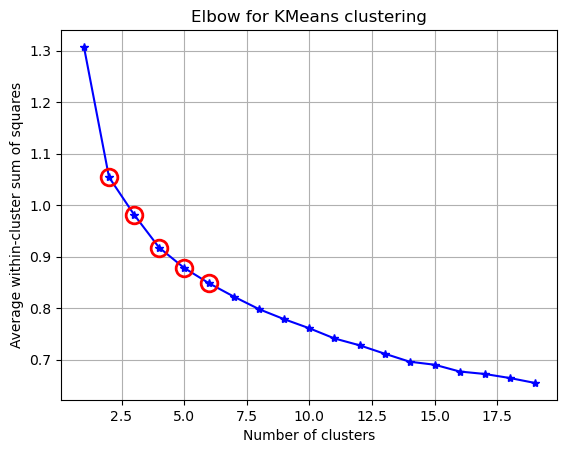

In [10]:
kIdx = [1, 2, 3, 4, 5]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
for d in kIdx:
    ax.plot(K[d], avgWithinSS[d], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

So probably around 3 clusters or so

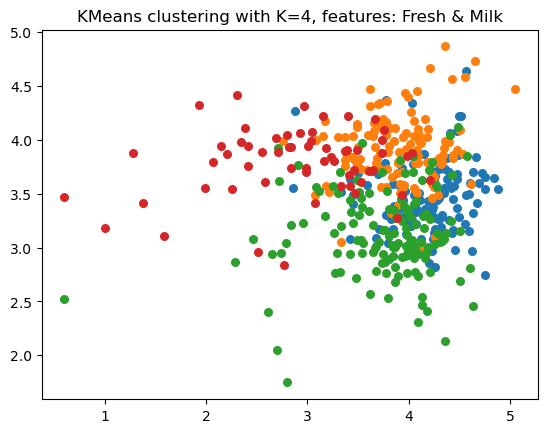

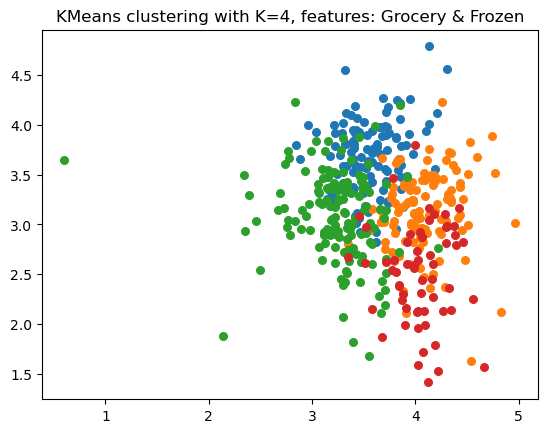

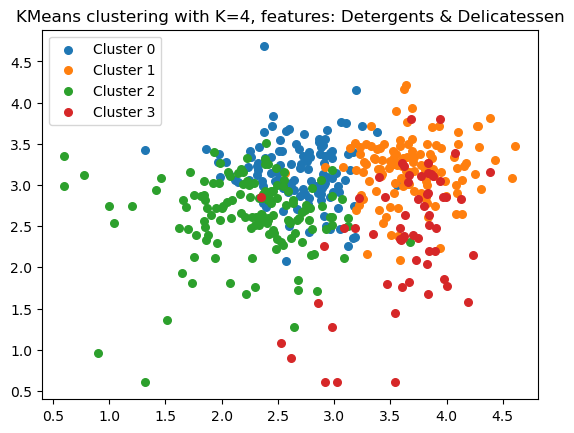

In [11]:
kIdx = 3  # equals 4 clusters

# scatter plot

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(data[ind,1],data[ind,2], s=30, label='Cluster %d'%i)
    #ax.plot(centroids[kIdx+1][i,1], centroids[kIdx+1][i,2], marker='o', markersize=12, markeredgewidth=2)
plt.title('KMeans clustering with K=%d, features: Fresh & Milk' % K[kIdx])

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(data[ind,3],data[ind,4], s=30, label='Cluster %d'%i)
    #ax.plot(centroids[kIdx+1][i,3], centroids[kIdx+1][i,4], marker='o', markersize=12, markeredgewidth=2)
plt.title('KMeans clustering with K=%d, features: Grocery & Frozen' % K[kIdx])

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(data[ind,5],data[ind,6], s=30, label='Cluster %d'%i)
    #ax.plot(centroids[kIdx+1][i,5], centroids[kIdx+1][i,6], marker='o', markersize=12, markeredgewidth=2)
plt.title('KMeans clustering with K=%d, features: Detergents & Delicatessen' % K[kIdx])

plt.legend()

plt.show()


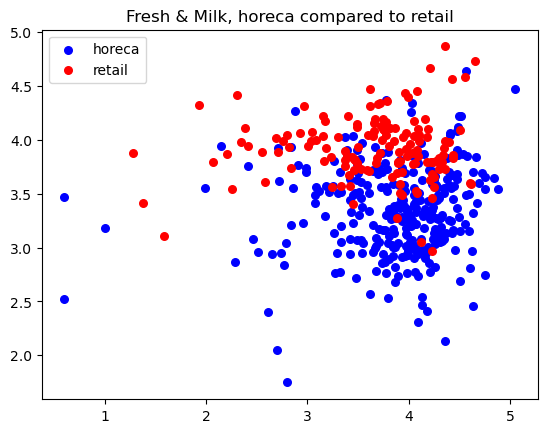

In [12]:
# now lets colour the dots according to the horeca-ness

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])

ax.scatter(data[np.argwhere(data[:,0]==1),1],data[np.argwhere(data[:,0]==1),2], s=30, c='b', label='horeca')

ax.scatter(data[np.argwhere(data[:,0]==2),1],data[np.argwhere(data[:,0]==2),2], s=30, c='r', label='retail')

    #ax.plot(centroids[kIdx+1][i,1], centroids[kIdx+1][i,2], marker='o', markersize=12, markeredgewidth=2)
plt.title('Fresh & Milk, horeca compared to retail')

plt.legend()

plt.show()

so cluster 0 and 1 seem to correspond to horecas, whereas clusters 2 and 3 seem to be made of retail (green seems to be a bigger kind of store whereas yellow might correspond to the portugal-equivalent of spätis)

In [13]:
# now lets see how that works out in fewer dimensions

from sklearn.manifold import TSNE

data_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15).fit_transform(data[:,1::]) 
#also only on spending data of course

In [14]:
data_embedded.shape

(440, 2)

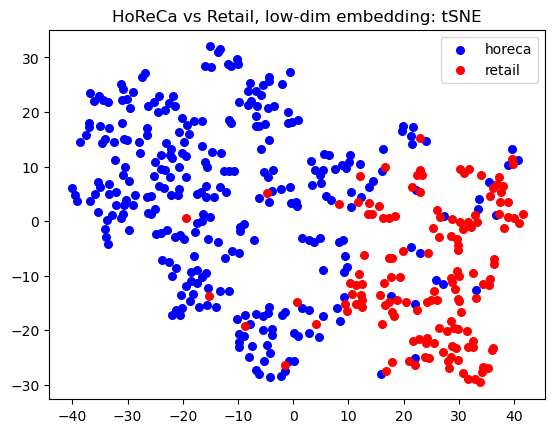

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(data_embedded[np.argwhere(data[:,0]==1),0],data_embedded[np.argwhere(data[:,0]==1),1], s=30, c='b', label='horeca')
ax.scatter(data_embedded[np.argwhere(data[:,0]==2),0],data_embedded[np.argwhere(data[:,0]==2),1], s=30, c='r', label='retail')

plt.title('HoReCa vs Retail, low-dim embedding: tSNE')

plt.legend()

plt.show()

Nice, there seems to bee some kind of natural differnce between the two.

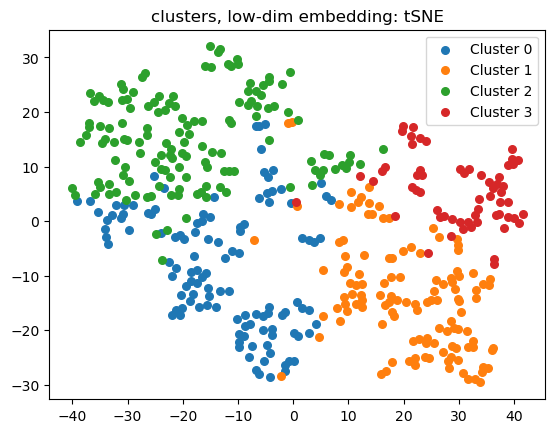

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(data_embedded[ind,0],data_embedded[ind,1], s=30, label='Cluster %d'%i)
    #ax.plot(centroids[kIdx+1][i,5], centroids[kIdx+1][i,6], marker='o', markersize=12, markeredgewidth=2)

plt.title('clusters, low-dim embedding: tSNE')

plt.legend()

plt.show()


doesnt that look nice?